In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from resnet50_get_relu_outputs import resnet_output
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
import plotly
from glob import glob
import nibabel as nb
import plotly.express as px

In [2]:
# Custom Dataset class to handle loading of images
class ImageDataset(Dataset):
    def __init__(self, folder, scanners):
        self.data = []
        for scanner in scanners:
            subs = sorted([sub for sub in os.listdir(folder+scanner+'/') if "S0" in sub])
            if len(subs)==0:
                pass
            else:
                # print(subs)
                for sub in subs:
                    # print(sub)

                    sessions = sorted([ses for ses in os.listdir(folder+scanner+'/'+sub) if "M0" in ses])
                    # print(sessions)
                    for ses in sessions:
                        image_list = sorted(glob(folder+scanner+'/'+sub+"/"+ses+"/axial/img_*.png"))
                        # print(image_list)
                        for img_name in image_list:
                            img_name = os.path.basename(img_name)
                            # print(img_name)
                            self.data.append((scanner, sub, ses, img_name))
        self.folder = folder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scanner, sub, ses, img_name = self.data[idx]
        print(img_name)
        img_path = f"{self.folder}/{scanner}/{sub}/{ses}/axial/{img_name}"
        img = plt.imread(img_path)[:, :, 0:3]

        print(img.shape)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize image
        img = img.transpose(2, 0, 1)  # Change shape to (C, H, W)
        return scanner, sub, ses, img_name, torch.tensor(img, dtype=torch.float32)

# Optimized UAE function to utilize PyTorch tensors and GPU acceleration
def uae(f_map):
    # f_map = f_map[0]
    # print(f_map.shape)
    value = torch.sum(f_map).item()
    return value / (f_map.shape[0] * f_map.shape[1] * f_map.shape[2])

# Function to process images in batches
def process_images(folder, scanners, model_resnet, batch_size=64):
    dataset = ImageDataset(folder, scanners)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    uae_data = {
        "scanner": [],
        "sub": [],
        "ses": [],
        "image": [],
        "UAE": [],
    }

    model_resnet.cuda()  # Move model to GPU
    model_resnet.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, desc="Processing Batches"):
            scanners, subs, sessions, img_names, imgs = batch
            print(scanners, subs, sessions, img_names, imgs.shape)
            imgs = imgs.cuda()  # Move images to GPU
            # print(imgs.shape)

            # Forward pass through the model
            activation_output, relu_names = resnet_output(model_resnet, imgs)

            # Process activations for each image in the batch
            for i in range(len(imgs)):
                value = [uae(activation_output[name][i]) for name in relu_names]
                # print(len(imgs))
                # value = [print(activation_output[name].shape) for name in relu_names]
                if np.isnan(value).any():
                    pass
                else:
                    uae_data["scanner"].append(scanners[i])
                    uae_data["sub"].append(subs[i])
                    uae_data["ses"].append(sessions[i])
                    uae_data["image"].append(img_names[i])
                    uae_data["UAE"].append(value)

    return uae_data

# Usage

folder = "/media/sarvagya-pc/2TB HDD/Balgrist/THS/images_combined_wp12s/"

output_folder = "/media/sarvagya-pc/2TB HDD/Balgrist/THS/"
# subs = ["sub1", "sub2", ...]  # List of subjects
scanners = sorted(os.listdir(folder))
to_remove = ['NOT', 'SNS']
for item in to_remove:
    if item in scanners:
        scanners.remove(item)
print(scanners)
# model_resnet = ...  # Your ResNet model
# model_to_test = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# model_to_test = models.vgg16(weights='VGG16_Weights.DEFAULT')
model_to_test = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
uae_data = process_images(folder, scanners, model_to_test)
output_filename = "images_densenet_64_wp12s.mat"
output_path = os.path.join(output_folder, output_filename)
savemat(output_path, uae_data)

['BCN', 'BSL', 'HD', 'ZH']


Processing Batches:   0%|          | 0/69 [00:00<?, ?it/s]

img_000.pngimg_064.pngimg_018.png
(145, 121, 3)


img_019.png(145, 121, 3)

(145, 121, 3)
img_065.png(145, 121, 3)

img_001.png
img_020.png
(145, 121, 3)
(145, 121, 3)img_066.png
(145, 121, 3)

img_002.png
img_021.png
(145, 121, 3)(145, 121, 3)

(145, 121, 3)img_003.pngimg_067.png


img_022.png
(145, 121, 3)(145, 121, 3)

(145, 121, 3)img_004.png
img_068.png

img_023.png
(145, 121, 3)(145, 121, 3)

img_082.png(145, 121, 3)img_005.png
img_069.png


img_024.png(145, 121, 3)
(145, 121, 3)

img_006.pngimg_070.png
(145, 121, 3)(145, 121, 3)


(145, 121, 3)img_025.png
(145, 121, 3)
img_083.png
img_007.png

img_071.png(145, 121, 3)

(145, 121, 3)(145, 121, 3)

img_026.png(145, 121, 3)
img_084.png
img_008.png

img_072.png(145, 121, 3)

(145, 121, 3)
img_027.png(145, 121, 3)
(145, 121, 3)img_085.png


img_009.png(145, 121, 3)img_073.png


(145, 121, 3)
img_028.png(145, 121, 3)
(145, 121, 3)img_086.png


img_010.pngimg_074.png(145, 121, 3)(145, 121, 3)



img_029.pngimg_087.png
(145, 121, 3)
(14

In [3]:
def entropy(p):
    """Calculate entropy for given probability distribution."""
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def mutual_information(x, y, bins=120):
    """Estimate mutual information for continuous variables."""
    # print(x.shape, y.shape)
    # Find the minimum length of the two arrays
    min_length = min(len(x), len(y))
    
    # Truncate x and y to the same length
    x = x[:min_length]
    y = y[:min_length]
    
    c_xy = np.histogram2d(x, y, bins)[0]
    p_xy = c_xy / np.sum(c_xy)  # Joint probability distribution
    p_x = np.sum(p_xy, axis=1)  # Marginal for x
    p_y = np.sum(p_xy, axis=0)  # Marginal for y
    
    # Calculate entropies
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_xy = entropy(p_xy.flatten())
    
    # Mutual information
    mi = h_x + h_y - h_xy
    return mi

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [4]:
print(len(uae_data["UAE"]))
uae_data["UAE"] = np.array(uae_data["UAE"])
uae_data["UAE"].reshape(len(uae_data["UAE"]), len(uae_data['UAE'][0]))
print(uae_data["UAE"].shape)

4400
(4400, 120)


In [5]:
matrices = {}
for scanner in np.unique(uae_data["scanner"]):
    idx_scanner = np.where(np.array(uae_data["scanner"]) == scanner)[0]
    print(idx_scanner[0], idx_scanner[-1])
    new_dict_for_each_scanner = {key: values[idx_scanner[0]:idx_scanner[-1]+1] for key, values in uae_data.items()}
    for sub in np.unique(uae_data["sub"]):
        idx_sub = np.where(np.array(new_dict_for_each_scanner["sub"]) == sub)[0]
        sessions = np.unique(new_dict_for_each_scanner["ses"][idx_sub[0]:idx_sub[-1]+1])
        
        new_dict_for_each_sub = {key: values[idx_sub[0]:idx_sub[-1]+1] for key, values in new_dict_for_each_scanner.items()}

        for ses in sessions:

            idx_ses = np.where(np.array(new_dict_for_each_sub["ses"]) == ses)[0]
            print(ses, sub, scanner, idx_ses[0], idx_ses[-1], idx_sub[0], idx_sub[-1])

            new_dict_for_each_ses_for_above_sub_each_scanner = {key: values[idx_ses[0]:idx_ses[-1]+1] for key, values in new_dict_for_each_sub.items()}

            # exec(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]+" = []")
            # print(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1])

    #         # exec(sub.split("-")[0]+ses.split("-")[0]+"_"+ses.split("-")[1]+".append()")

            print(new_dict_for_each_ses_for_above_sub_each_scanner["UAE"].shape)
            matrix_key = scanner+sub+ses
            # print(matrix_key)
            matrices[matrix_key] = new_dict_for_each_ses_for_above_sub_each_scanner["UAE"]

0 1099
M01 S01 BCN 0 109 0 219
(110, 120)
M02 S01 BCN 110 219 0 219
(110, 120)
M01 S02 BCN 0 109 220 439
(110, 120)
M02 S02 BCN 110 219 220 439
(110, 120)
M01 S03 BCN 0 109 440 659
(110, 120)
M02 S03 BCN 110 219 440 659
(110, 120)
M01 S04 BCN 0 109 660 879
(110, 120)
M02 S04 BCN 110 219 660 879
(110, 120)
M01 S05 BCN 0 109 880 1099
(110, 120)
M02 S05 BCN 110 219 880 1099
(110, 120)
1100 2199
M01 S01 BSL 0 109 0 219
(110, 120)
M02 S01 BSL 110 219 0 219
(110, 120)
M01 S02 BSL 0 109 220 439
(110, 120)
M02 S02 BSL 110 219 220 439
(110, 120)
M01 S03 BSL 0 109 440 659
(110, 120)
M02 S03 BSL 110 219 440 659
(110, 120)
M01 S04 BSL 0 109 660 879
(110, 120)
M02 S04 BSL 110 219 660 879
(110, 120)
M01 S05 BSL 0 109 880 1099
(110, 120)
M02 S05 BSL 110 219 880 1099
(110, 120)
2200 3299
M01 S01 HD 0 109 0 219
(110, 120)
M02 S01 HD 110 219 0 219
(110, 120)
M01 S02 HD 0 109 220 439
(110, 120)
M02 S02 HD 110 219 220 439
(110, 120)
M01 S03 HD 0 109 440 659
(110, 120)
M02 S03 HD 110 219 440 659
(110, 120)

In [6]:
matrix_sub = list(matrices.keys())
num_matrices = len(matrix_sub)
uae_points = len(uae_data['UAE'][0])
mi_matrix = np.zeros((num_matrices, num_matrices, uae_points))
print(matrix_sub)

for i in tqdm(range(len(matrix_sub))):
    print(matrix_sub[i])
    for j in range(i, len(matrix_sub)):
        for k in range(uae_points):
            mi = mutual_information(matrices[matrix_sub[i]][:, k], matrices[matrix_sub[j]][:, k], 500)
            mi_matrix[i, j, k] = mi
            mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric

# # Normalize the mutual information matrix per row (subject-wise)
# for i in range(num_matrices):
#     for k in range(uae_points):
#         row = mi_matrix[i, :, k]
#         mi_matrix[i, :, k] = (row - np.min(row)) / (np.max(row) - np.min(row) + 1e-10)  # Normalization to [0, 1]

# # Normalize the mutual information matrix per column (scanner-wise)
# for j in range(num_matrices):
#     for k in range(uae_points):
#         col = mi_matrix[:, j, k]
#         mi_matrix[:, j, k] = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-10)  # Normalization to [0, 1]

['BCNS01M01', 'BCNS01M02', 'BCNS02M01', 'BCNS02M02', 'BCNS03M01', 'BCNS03M02', 'BCNS04M01', 'BCNS04M02', 'BCNS05M01', 'BCNS05M02', 'BSLS01M01', 'BSLS01M02', 'BSLS02M01', 'BSLS02M02', 'BSLS03M01', 'BSLS03M02', 'BSLS04M01', 'BSLS04M02', 'BSLS05M01', 'BSLS05M02', 'HDS01M01', 'HDS01M02', 'HDS02M01', 'HDS02M02', 'HDS03M01', 'HDS03M02', 'HDS04M01', 'HDS04M02', 'HDS05M01', 'HDS05M02', 'ZHS01M01', 'ZHS01M02', 'ZHS02M01', 'ZHS02M02', 'ZHS03M01', 'ZHS03M02', 'ZHS04M01', 'ZHS04M02', 'ZHS05M01', 'ZHS05M02']


  0%|          | 0/40 [00:00<?, ?it/s]

BCNS01M01
BCNS01M02
BCNS02M01
BCNS02M02
BCNS03M01
BCNS03M02
BCNS04M01
BCNS04M02
BCNS05M01
BCNS05M02
BSLS01M01
BSLS01M02
BSLS02M01
BSLS02M02
BSLS03M01
BSLS03M02
BSLS04M01
BSLS04M02
BSLS05M01
BSLS05M02
HDS01M01
HDS01M02
HDS02M01
HDS02M02
HDS03M01
HDS03M02
HDS04M01
HDS04M02
HDS05M01
HDS05M02
ZHS01M01
ZHS01M02
ZHS02M01
ZHS02M02
ZHS03M01
ZHS03M02
ZHS04M01
ZHS04M02
ZHS05M01
ZHS05M02


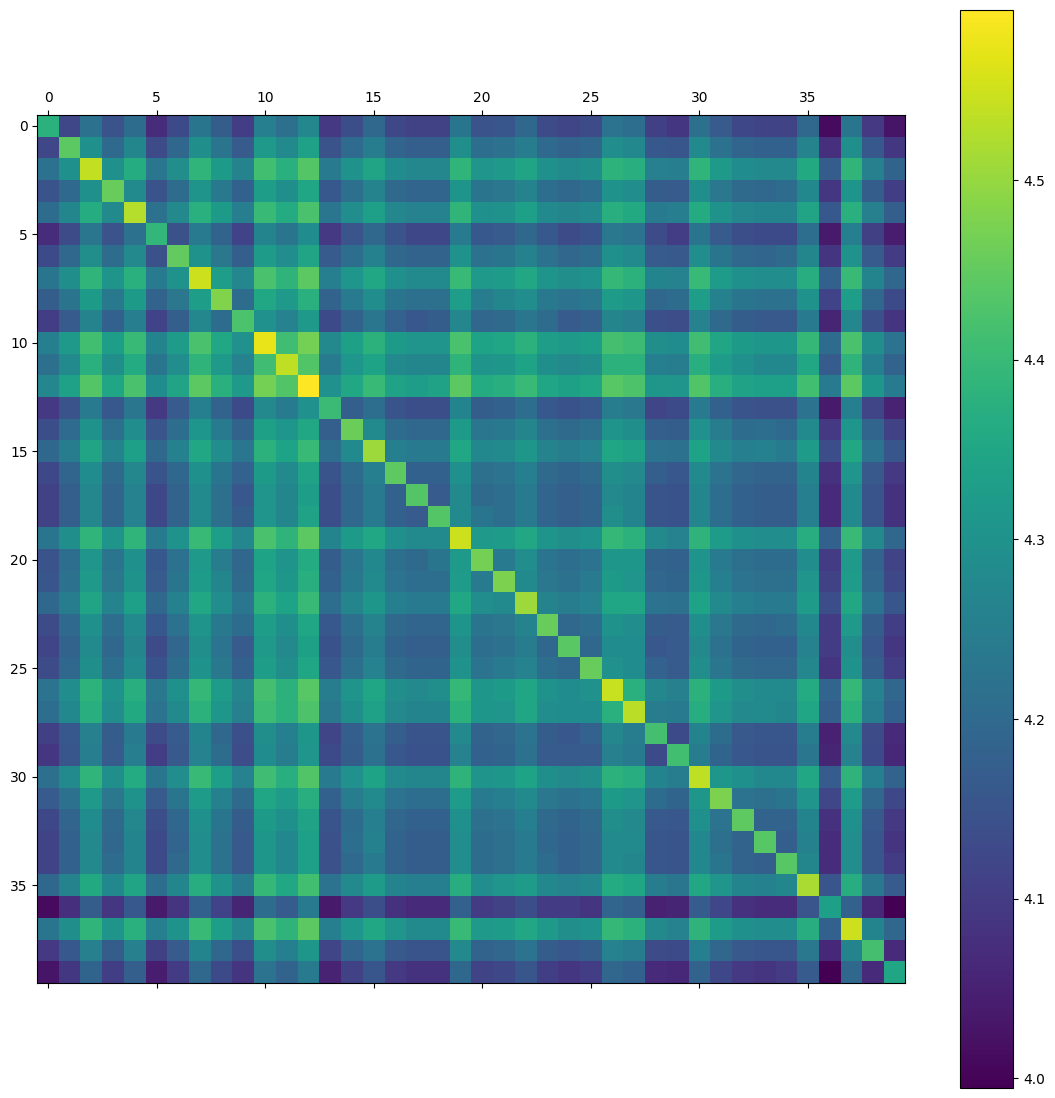

In [7]:
data = mi_matrix[:,:,1]

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

In [14]:
y = np.average(mi_matrix[:,:,:], axis=2)
# y_bin = (y>4.3)*1
fig = px.imshow(y, x = matrix_sub, y = matrix_sub, text_auto=True)
fig.layout.height = 1000
fig.layout.width = 1000
fig.show()